# 01 Import Libraries

In [1]:
import os
import re
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import label

# 02 Slice Image Acquisition & Visualization

In [2]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)
        
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))

    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))
    
    return (slices, ID)

In [3]:
slices, PatientID = readSortedSlices('sample-dataset')
slices

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


['sample-dataset/ID00007637202177411956430_0.jpg',
 'sample-dataset/ID00007637202177411956430_1.jpg',
 'sample-dataset/ID00007637202177411956430_2.jpg',
 'sample-dataset/ID00007637202177411956430_3.jpg',
 'sample-dataset/ID00007637202177411956430_4.jpg',
 'sample-dataset/ID00007637202177411956430_5.jpg',
 'sample-dataset/ID00007637202177411956430_6.jpg',
 'sample-dataset/ID00007637202177411956430_7.jpg',
 'sample-dataset/ID00007637202177411956430_8.jpg',
 'sample-dataset/ID00007637202177411956430_9.jpg',
 'sample-dataset/ID00007637202177411956430_10.jpg',
 'sample-dataset/ID00007637202177411956430_11.jpg',
 'sample-dataset/ID00007637202177411956430_12.jpg',
 'sample-dataset/ID00007637202177411956430_13.jpg',
 'sample-dataset/ID00007637202177411956430_14.jpg',
 'sample-dataset/ID00007637202177411956430_15.jpg',
 'sample-dataset/ID00007637202177411956430_16.jpg',
 'sample-dataset/ID00007637202177411956430_17.jpg',
 'sample-dataset/ID00007637202177411956430_18.jpg',
 'sample-dataset/ID000

In [4]:
def readImg(path):
    img = cv2.imread(path)
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

In [5]:
sliceImgs = getSliceImages(slices)

In [6]:
def showImages(slices, cols, ID):
    sliceCount = len(slices)
    rows = int(sliceCount / cols)

    fig, ax = plt.subplots(nrows = rows if sliceCount % cols == 0 else rows + 1 , 
                           ncols = cols, 
                           figsize = (20, 50))
    counter = 0
    for i in range(rows):
        for j in range(cols):
            
            ax[i, j].imshow(slices[counter], cmap ='gray')
            ax[i,j].set_title('Slice %d' % (counter + 1))
            ax[i,j].axis('off')
            counter += 1

    if (sliceCount / cols) != rows:
        for j in range(sliceCount % cols):
            ax[rows,j].imshow(slices[counter], cmap ='gray')
            ax[rows,j].set_title('Slice %d' % (counter + 1))
            ax[rows,j].axis('off')
            counter += 1
            
    plt.show()

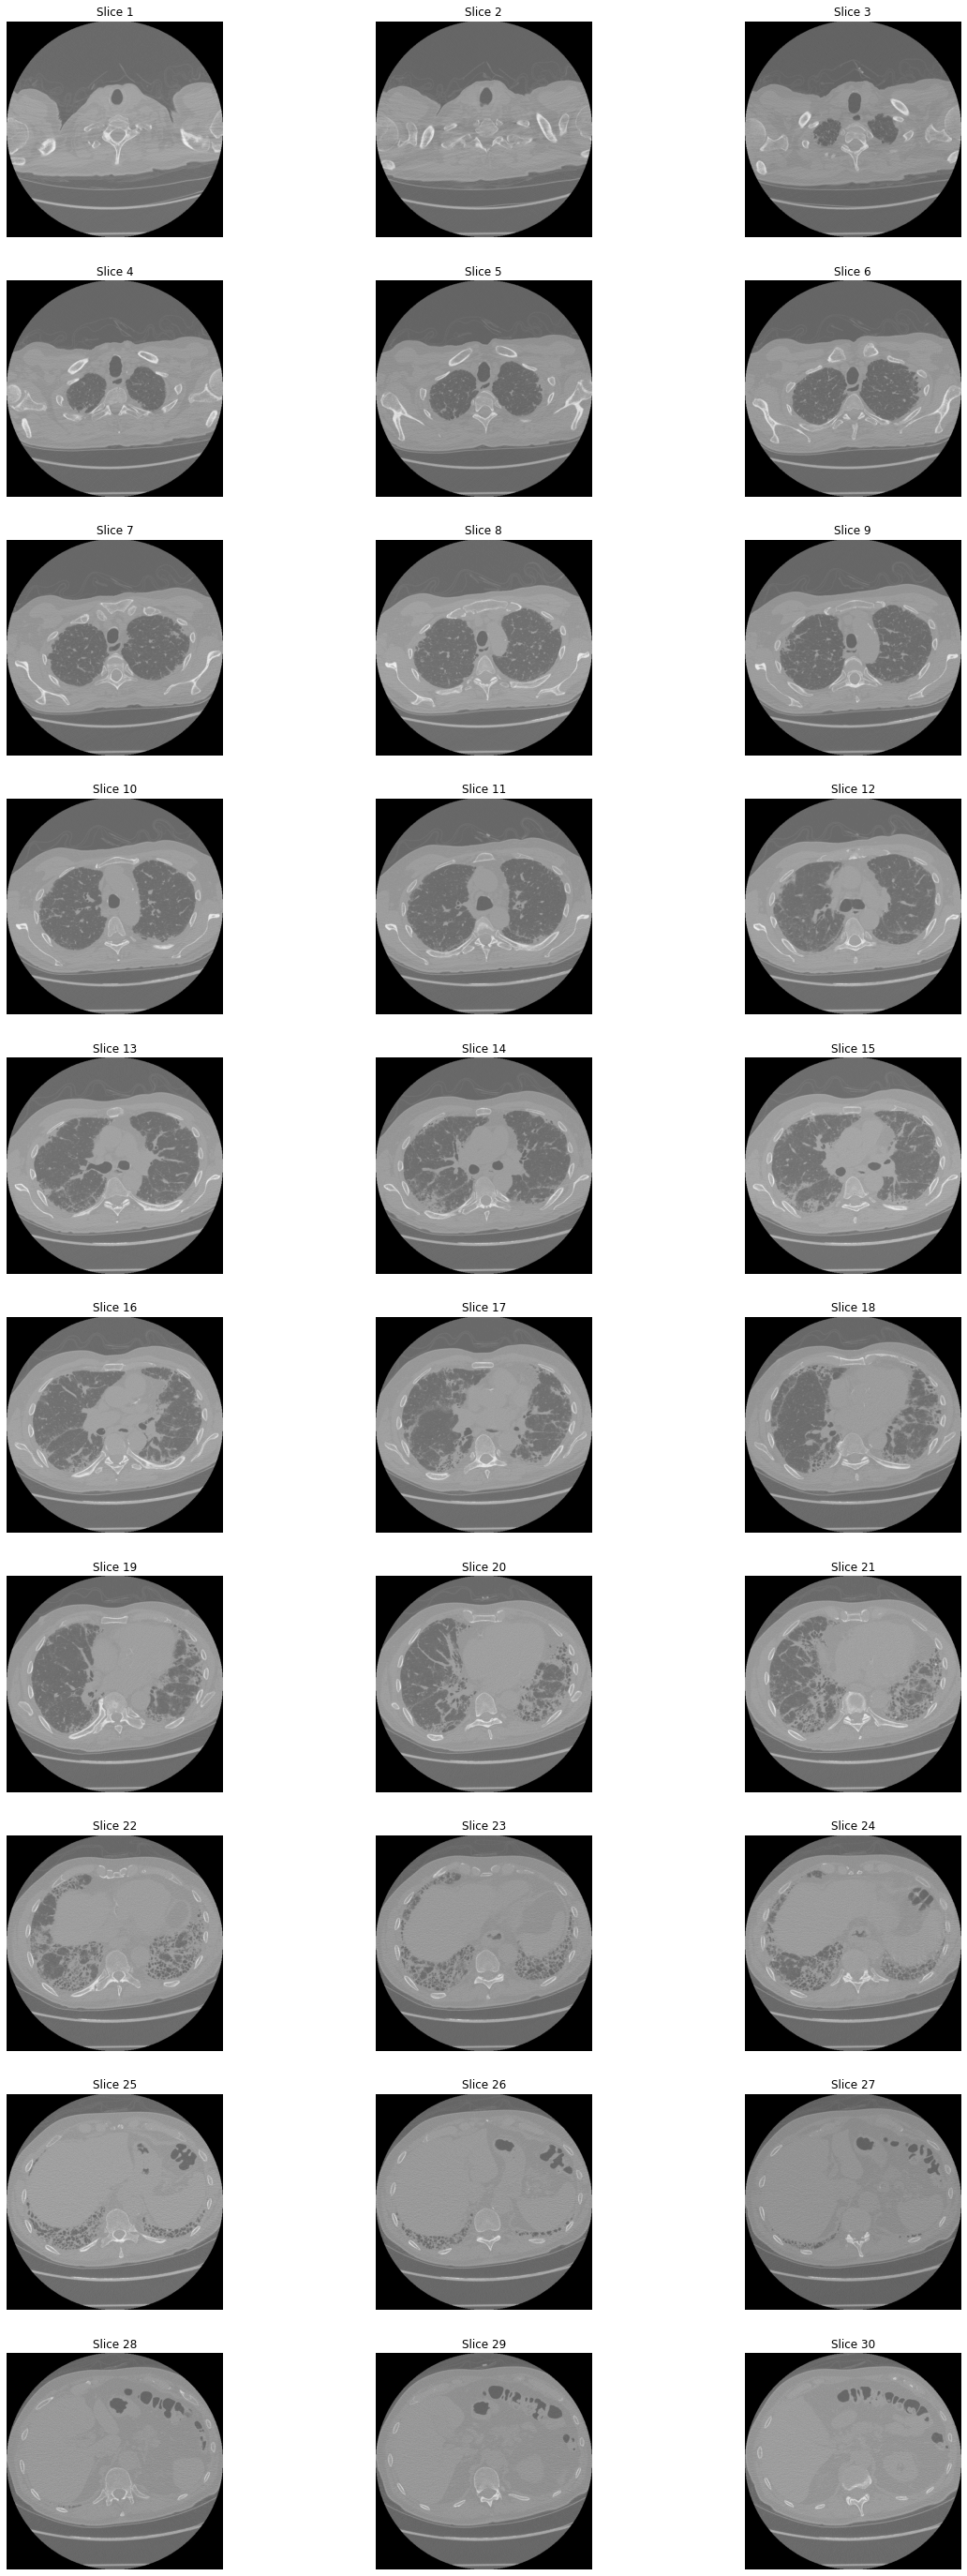

In [7]:
showImages(sliceImgs, 3, PatientID)

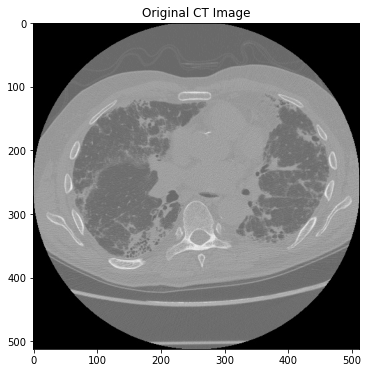

In [8]:
plt.figure(figsize = (12, 6))
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg')
plt.title('Original CT Image')
plt.imshow(im, cmap='gray')
plt.show()

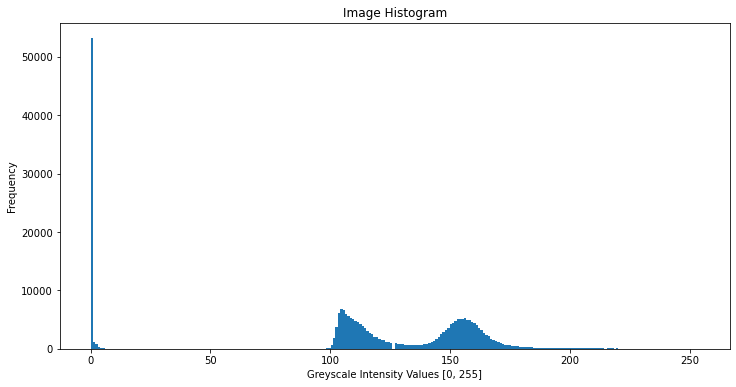

In [9]:
plt.figure(figsize = (12, 6))

plt.title('Image Histogram')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

In [10]:
im[im < 0]

array([], dtype=uint8)

In [11]:
im[im > 255]

array([], dtype=uint8)

# 03 Slice Image Preprocessing
## 3.1 Calculate Statistically Derived Thresholds 
Obtain the statistically derived thresholds needed in order to define the binary masks. These thresholds depend on the distribution of the image histogram.
### 3.1.1 Mean Value of Intensity of Pixels, $\mu(k)$

In [12]:
# Calculate the average intensity of the kth slice
mu_k = im.mean()
mu_k

107.61984634399414

Text(0.5, 1.0, 'Binary Image after Thresholding with the Mean')

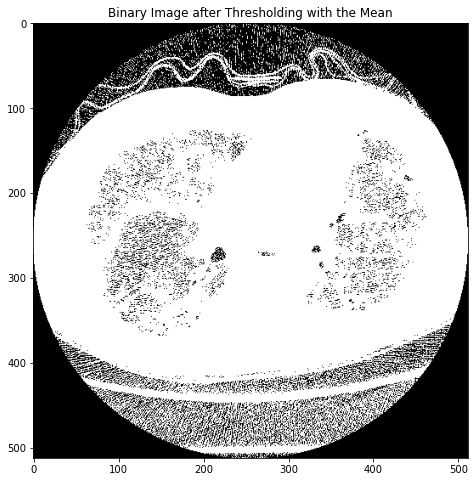

In [13]:
# Create a binary mask by thresholding with the average
bmask = cv2.threshold(im, mu_k, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 8))
plt.imshow(bmask[1], cmap='gray')
plt.title('Binary Image after Thresholding with the Mean')

### 3.1.2 Mean Value of Pixels with Intensity $> \mu(k), \mu_{sup} (k)$
The output binary mask determines the position of the spine in a slice.

In [14]:
pixelsGreaterThanMean = np.where(im.flatten() > mu_k)[0]
R_k = len(pixelsGreaterThanMean)
R_k

174524

In [15]:
levelsGreaterThanMean = im.flatten()[pixelsGreaterThanMean]

In [16]:
mu_sup_k = levelsGreaterThanMean.mean()
mu_sup_k

142.48654626297815

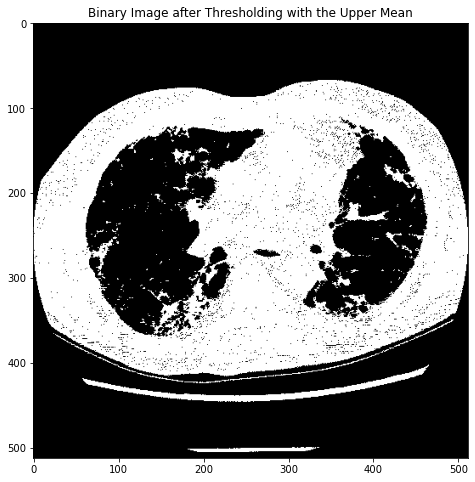

In [17]:
# Create a binary mask by thresholding with the average
bmask2 = cv2.threshold(im, mu_sup_k, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 8))
plt.imshow(bmask2[1], cmap='gray')
plt.title('Binary Image after Thresholding with the Upper Mean')
plt.show()

### 3.1.3 Standard Deviation of Intensities of Pixels with Intensity $>\mu(k), \sigma_{sup}(k)$

In [18]:
# Calculate standard deviation
sigma_k = im.flatten()[pixelsGreaterThanMean].std()
sigma_k

22.968593239803816

### 3.1.4 Threshold to locate rib bones & structures with oxygenated blood flow: $\mu(k) + \sigma_{sup}(k)$ 

In [19]:
muSupSDBinMask = im > mu_sup_k + sigma_k

Text(0.5, 1.0, 'Binary Image after Thresholding with the Upper Mean + Std Dev of Upper Distribution')

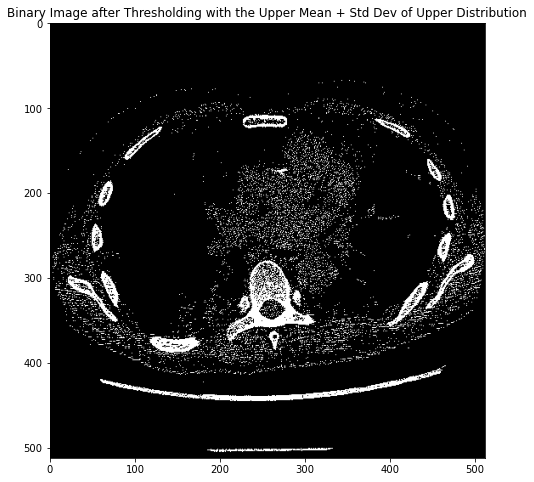

In [20]:
plt.figure(figsize=(10, 8))
plt.imshow(muSupSDBinMask, cmap='gray')
plt.title('Binary Image after Thresholding with the Upper Mean + Std Dev of Upper Distribution')

#### Histogram with the Calculated Statistical Parameters

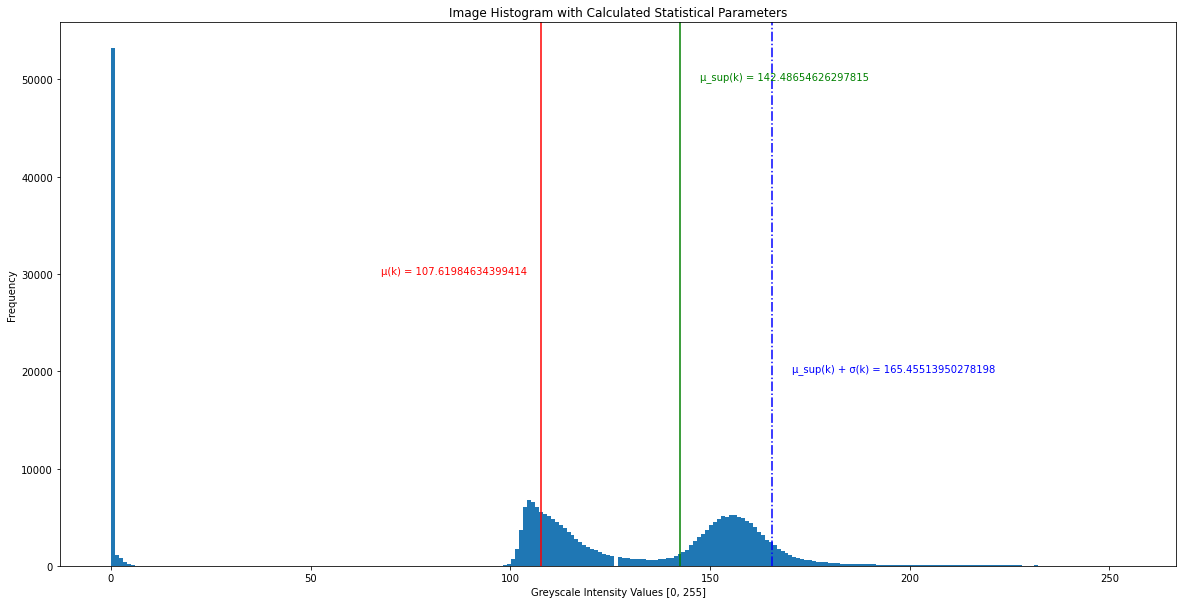

In [21]:
plt.figure(figsize = (20, 10))

# Mean line
plt.axvline(x = mu_k, c = 'red')
plt.text(x = mu_k - 40, 
         y = 30000, 
         s = "μ(k) = " + str(mu_k), 
         c = 'red')

# Upper mean line
plt.axvline(x = mu_sup_k, c = 'green')
plt.text(x = mu_sup_k + 5, 
         y = 50000, 
         s = "μ_sup(k) = " + str(mu_sup_k), 
         c = 'green')


# Upper mean + Std Dev line
plt.axvline(x = mu_sup_k + sigma_k, c = 'blue', linestyle = '-.' )
plt.text(x = mu_sup_k + sigma_k + 5, 
         y = 20000, 
         s = "μ_sup(k) + σ(k) = " + str(mu_sup_k + sigma_k), 
         c = 'blue')

plt.title('Image Histogram with Calculated Statistical Parameters')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

### 3.1.5 Global Mean, $\mu_{global}(k) = Mean(\mu_{sup}(k)) - StdDev(\mu_{sup}(k))$ 
Thresholding with $\mu_{global}$ shows parts of the images constituting muscular tissues.
To calculate the global mean, we iterate through each slice of a patient.

In [22]:
mu_sups = []

# For each slice, calculate upper mean and append to the list
for i in range(len(sliceImgs)):
    ctSlice = sliceImgs[i].flatten()
    
    # Calculate mean of Slice i
    mu_i = ctSlice.mean()
    
    # Calculate the upper mean of Slice i
    greaterThanMu = np.where(ctSlice > mu_i)[0]
    mu_sup_i = ctSlice[greaterThanMu].mean()
    
    mu_sups.append(mu_sup_i)
# mu_sups

Text(0.5, 1.0, 'Binary Image after Thresholding with the Global Mean')

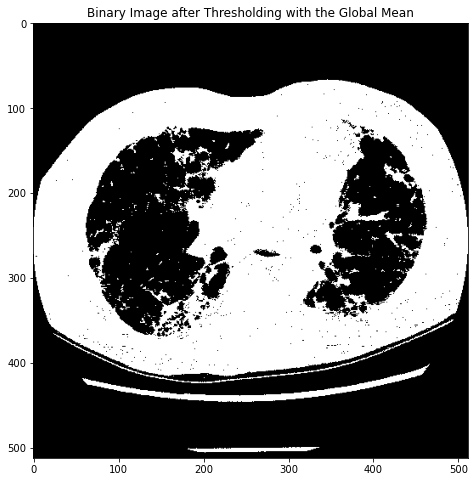

In [23]:
# Calculate the global mean
mu_global = np.mean(mu_sups) - np.std(mu_sups)

# Perform thresholding on one slice with the global mean
mu_global_bMask = im > mu_global

# Show the binary image after thresholding
plt.figure(figsize=(10, 8))
plt.imshow(mu_global_bMask, cmap='gray')
plt.title('Binary Image after Thresholding with the Global Mean')

## Display all masks

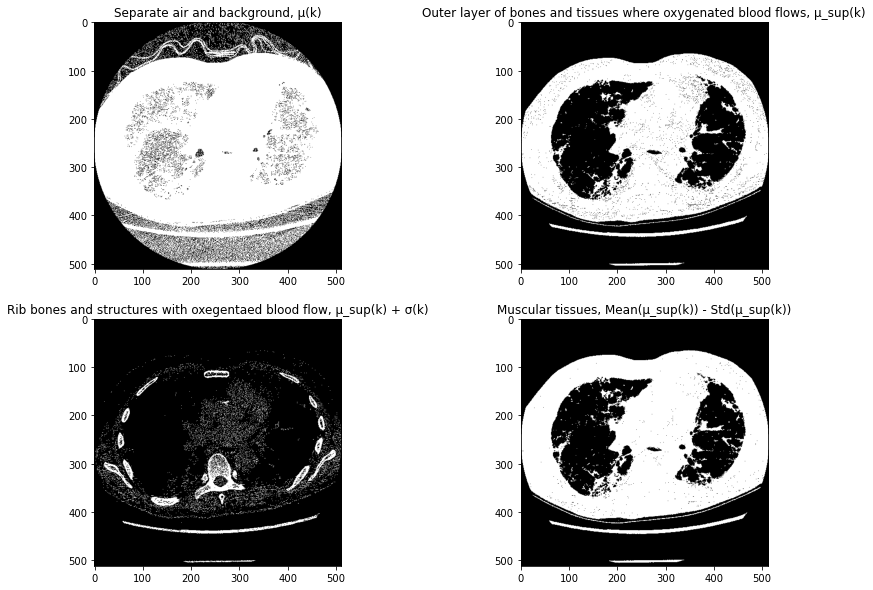

In [24]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize = (14,10))

ax[0,0].imshow(bmask[1], cmap ='gray')
ax[0,0].set_title('Separate air and background, μ(k)')

# Roughly determines the position of spine
ax[0,1].imshow(bmask2[1], cmap ='gray')
ax[0,1].set_title('Outer layer of bones and tissues where oxygenated blood flows, μ_sup(k)')

# Used later in order to locate the descending aorta in all the slices of the volumetric scan
ax[1,0].imshow(muSupSDBinMask, cmap ='gray')
ax[1,0].set_title('Rib bones and structures with oxegentaed blood flow, μ_sup(k) + σ(k)')

# 
ax[1,1].imshow(mu_global_bMask, cmap ='gray')
ax[1,1].set_title('Muscular tissues, Mean(μ_sup(k)) - Std(μ_sup(k))')

plt.show()

# 04 Locating spine and aorta regions
## Position of the spine and the aorta
Both spine and the descending aorta are present in all slices of the axial scan.

1. _S_ binary masks are obtained by thresholding each CT slice with it's corresponding parameter $\mu_{sup}(k)$.
2. The area common to all these masks is computed (logical _AND_).
    (The resulting pixels belong either to _spine_ or _aorta_)
3. Morphological dialation is performed, so that non-connected pixels in the spine region do not cause faults.
4. The object of highest area is used as a mask for selecting the _spine_ in all slices.
5. The location of _aorta_ is found by the common area of thresholding each slice with its corresponding $\mu_{sup}(k) + \sigma_{sup}(k)$.

Helper function to visualize multiple plots

In [25]:
def multiple_plots(images, n_cols = 5):
    
    count = len(images)
    
    if count % n_cols == 0:
        n_rows = count//n_cols
    else:
        n_rows = count//n_cols + 1
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,20))
    
    for i in range(n_rows):
        for j in range(n_cols):
            if i*n_cols + j < count:
                ax[i][j].imshow(images[i*n_cols + j], cmap='gray')
                ax[i][j].set_title('Slice %d' %(i*n_cols + j + 1))
                ax[i][j].axis('off')
            else:
                break
    
    plt.show()

Helper function to get the masked image

In [26]:
def image_from_mask(image, mask):
    new_image = np.ones((image.shape))*0
    windex = (mask == True)
    new_image[windex] = image[windex]
    return new_image

### 4.1 Spine and Aorta Regions
Using the process described above the spine and aorta regions are extracted for a particular patient

In [27]:
def spine_and_aorta_region(slices):
    # Visual purpose
    spine_masks = []
    aorta_masks = []

    spine_mask = np.ones((slices[0].shape))
    aorta_mask = np.ones((slices[0].shape))
    
    for i in range(len(slices)):
        ct_slice = slices[i]

        # Calculate mu_sup(k) and sigma_sup(k)
        mu = ct_slice.mean()

        pixels_greater_than_mean = np.where(ct_slice.flatten() > mu)[0]
        greater_than_mean = ct_slice.flatten()[pixels_greater_than_mean]
        
        mu_sup_k = greater_than_mean.mean()
        sigma_sup_k = greater_than_mean.std()
        
        mu_sup_binary_mask = ct_slice > mu_sup_k
        sigma_sup_binary_mask = ct_slice > mu_sup_k + sigma_sup_k
         
        spine_masks.append(mu_sup_binary_mask)
        aorta_masks.append(sigma_sup_binary_mask)

        spine_mask = spine_mask * mu_sup_binary_mask
        aorta_mask = aorta_mask * sigma_sup_binary_mask
    
    return spine_mask, aorta_mask, spine_masks, aorta_masks

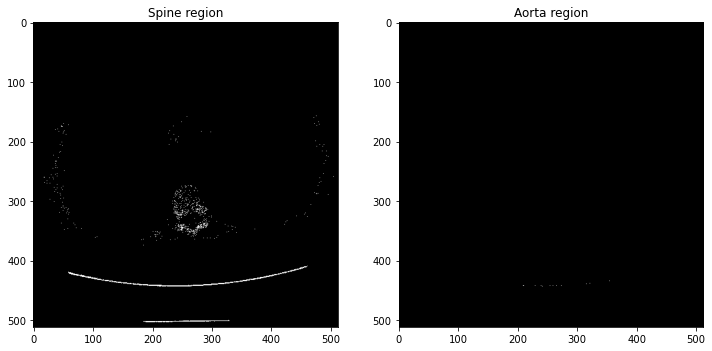

In [28]:
spine, aorta, _, aorta_inter = spine_and_aorta_region(sliceImgs)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12,8))
ax[0].imshow(spine, 'gray')
ax[0].set_title('Spine region')

ax[1].imshow(aorta, 'gray')
ax[1].set_title('Aorta region')

plt.show()

We observe that the aorta region is incorrectly specified. This is due to the fact that the initial CT slices available in the data are from lower body, where aorta is absent. And hence, a logical _AND_ operation of all masks, marks the aorta region incorrectly. 

A possible treatment would be to determine the position of aorta excluding the initial few slices, based on some statistical parameters like, area etc.

#### Below is a plot of the masks obtained to mark the aorta region in each slice.

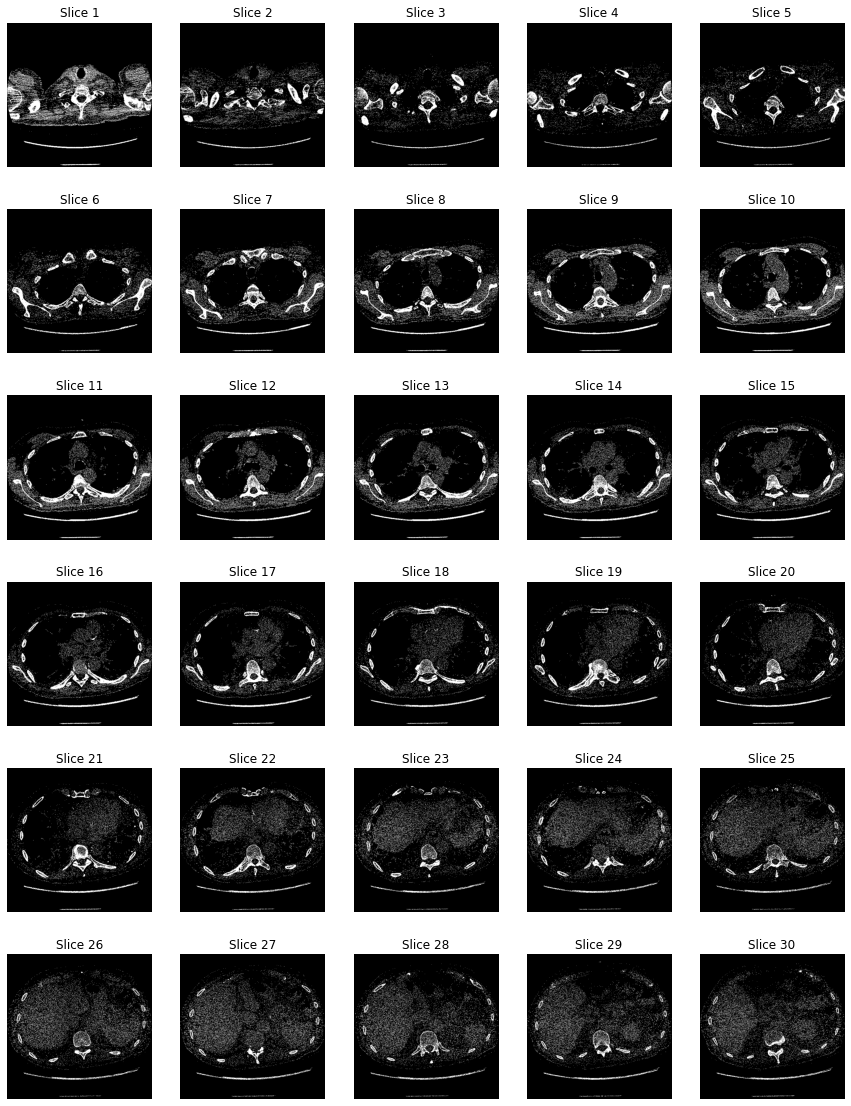

In [29]:
multiple_plots(aorta_inter)

Helper function to get the object of highest area from a binary image.

In [30]:
def highest_area_object(image, at_least_one_object = False):
    '''
    Returns the largest area object in a binary image
    '''    
    #Label connected regions of 1s from the binary_mask (contains only 0s and 1s).
    labels = label(image)
    #tests if at least 1 object exists in image
    if at_least_one_object == True:
        assert( labels.max() != 0 ) 
    
    #create array with 1 values correspoding to bigest'objects label
    if len(np.bincount(labels.flatten())) == 1:
        return(image)
    else:
        largest_object = labels == np.argmax(np.bincount(labels.flatten())[1:])+1
        return (largest_object)

In [31]:
def return_pulses(profile):
    
    '''
    Returns a list of lists cointaining all the pulses seperatly contained in each of the M profiles
    of the slice along with the list of their indexes.

    A pulse is a sequence of 1s in each binary masked profile.
    The number of pulses is equal or greater than 0
    In case of 0 pulses the function returns a list of a (0,0) tuple.
    '''
    
    stacked = np.hstack(([0], profile, [0]))
    # find the first index of each sequence of 1s
    start = (np.diff(stacked) > 0)
    
    # find the last index of each sequence of 1s
    end = (np.diff(stacked) < 0)
    
    number_of_pulses = len(np.where(start == True)[0])
    
    pulses = []
    
    for i in range(number_of_pulses):
        start_index = np.where(start == True)[0][i]
        end_index = np.where(end == True)[0][i]
        
        pulses.append([profile[start_index:end_index],list(range(start_index,end_index))])
 
    if pulses == []:
        return [(0,0)]
    
    else:
        return (pulses)

# 05 Automatic Region Selection
_This algorithm post processses the final mask to automatically segment the cardiac region._

First, 1-Dimensional profiles are created corresponding to each column of the final mask.
Next, processing is done to select ROI based on the number and width of the 1-Dimensional profiles.

In [32]:
def ROI(image):
    '''
    Returns the region of interest for a single CT-slice.
    '''
    # rows and columns of k_th slice
    N, M = image.shape

    # Mean value of the intensity of the pixels, μ(k)
    mu_k = image.mean()
 
    # STEP 1
    # Apply binary mask on k_th slice by thresholding with μ(k)
    binary_mask = image > mu_k

    # STEP 2
    # Keep only object of highest number of pixels / highest area
    binary_mask = highest_area_object(binary_mask)

    # STEP 3 Initialiase width values
    # initialize width_mean 
    width_mean = 0.1 * N
    
    # initialize width_max
    width_max = 0.3 * N
    
    # STEP 4  
    for j in range(M):
        profile = np.asarray(binary_mask[:,j])

        # leftmost pulse of the jth profile i.e. the 1st pulse of the jth profile
        first_pulse, index = return_pulses(profile)[0]

        # if 0 pulses in the profile do nothing
        if isinstance(first_pulse, np.ndarray) == False:
            width_mean = 0
            continue

        # set width_j as the width of leftmost pulse i.e. the number of the first (sequenced) 1s in the jth profile
        w_j = len(first_pulse)

        if w_j < width_max:
            width_mean = w_j
            # set to 0 the uppermost wj pixels with a value of 1 in the jth column of the binary mask
            binary_mask[index,j] = False
        
        else:
            # set to 0 the upperpmost wj pixels with a value of 1 in the jth column of the binary mask
            binary_mask[index[0]:index[0] + int(width_mean),j] = False   
    
    # Select the largest area object
    binary_mask = highest_area_object(binary_mask)
    return binary_mask

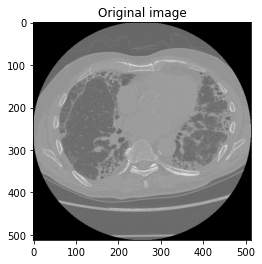

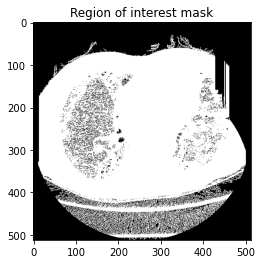

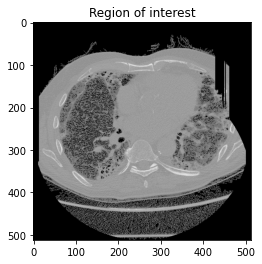

In [33]:
image = sliceImgs[17]
plt.imshow(image, 'gray')
plt.title("Original image")
plt.show()

region_of_interest = ROI(image)

plt.imshow(region_of_interest, 'gray')
plt.title("Region of interest mask")
plt.show()

original_masked = image_from_mask(image, region_of_interest)
plt.imshow(original_masked, 'gray')
plt.title("Region of interest")
plt.show()